In [1]:
import numpy as np
import cv2
import pickle
import matplotlib.pyplot as plt
import time
import pandas as pd
import argparse

import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms

from ripser import Rips
from persim import plot_diagrams, bottleneck

from manifold_torch import Manifold_Image_Sampler

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def normalize(v, r):
    return v/np.sqrt(np.sum(v**2))*r

EXPERIMENT = 'mnist'
RADIUS = 0.001
MULTIPLIER = 100
DIM = 2
SHUFFLE = False
RUNS = 2
TARGET = 1

print("EXPERIMENT: ", EXPERIMENT)
print("TARGET: ", TARGET)
print("RUNS: ", RUNS)
print("RADIUS: ", RADIUS)
print("MULTIPLIER: ", MULTIPLIER)
print("DIM: ", DIM)

EXPERIMENT:  mnist
TARGET:  1
RUNS:  2
RADIUS:  0.001
MULTIPLIER:  100
DIM:  2


In [2]:
if EXPERIMENT == 'fashion_mnist':
    print("Loading fashion mnist")
    train_set = torchvision.datasets.FashionMNIST("./data", download=True, transform=
                                                    transforms.Compose([transforms.ToTensor()]))
    test_set = torchvision.datasets.FashionMNIST("./data", download=True, train=False, transform=
                                                   transforms.Compose([transforms.ToTensor()]))
elif EXPERIMENT == 'mnist':
    print("Loading mnist")
    train_set = torchvision.datasets.MNIST("./data", download=True, transform=
                                                    transforms.Compose([transforms.ToTensor()]))
    test_set = torchvision.datasets.MNIST("./data", download=True, train=False, transform=
                                                   transforms.Compose([transforms.ToTensor()]))
else:
    print("Nothing to do.")
    
print("Done loading")
    
train_loader = torch.utils.data.DataLoader(train_set, 
                                           batch_size=100)
test_loader = torch.utils.data.DataLoader(test_set,
                                          batch_size=100)


all_loader = torch.utils.data.DataLoader(train_set, batch_size=train_set.__len__())
# all_loader = torch.utils.data.DataLoader(train_set, batch_size=1000)
all_images, all_labels = next(iter(all_loader))

start_time = time.time()
manifold_sampler = Manifold_Image_Sampler(all_images, dim = DIM, labels = all_labels)
duration = time.time() - start_time
print("Initialize duration: ", duration)


Loading mnist
Done loading
Initialize duration:  70.94929003715515


In [3]:
manifold_sampler.get_pivots(manifold_sampler.labels, 1000, shuffle = SHUFFLE, target_labels=[1])
manifold_G = manifold_sampler.get_G_from_pivots()

In [4]:
# if TARGET == None:
#     targets = np.array(torch.unique(all_labels))
#     target_str = 'all'
# else:
#     targets = [TARGET]
#     target_str = str(TARGET)

# # Get the hyperplanes
# _, pivots = manifold_sampler.get_pivots(manifold_sampler.labels, MULTIPLIER, shuffle = SHUFFLE, target_labels=targets)
# manifold_G = manifold_sampler.get_G_from_samples(pivots)
# Gu, Gd, Gv = np.linalg.svd(manifold_G, full_matrices=False)

byff = manifold_sampler.get_pivots(manifold_sampler.labels, 5, shuffle = False, target_labels=[1])
# manifold_G = manifold_sampler.get_G_from_pivots()

In [4]:
Gu, Gd, Gv = np.linalg.svd(manifold_G, full_matrices=False)

In [5]:
# Generate noise
perturbed_xtrain = np.random.normal(0, 1, size=manifold_sampler.pivots.shape)

In [6]:
raw_noise_1d = manifold_sampler.to_1d(perturbed_xtrain)
plane_noise = np.zeros_like(raw_noise_1d)

for d in range(Gv.shape[0]):
    proj = np.dot(raw_noise_1d, Gv[d])
    for s in range(plane_noise.shape[0]):
        plane_noise[s] = plane_noise[s] + proj[s]*Gv[d]        
ortho_noise = raw_noise_1d - plane_noise

In [7]:
print(np.sum(np.abs(np.dot(plane_noise,manifold_G.T))))
print(np.sum(np.abs(np.dot(ortho_noise,manifold_G.T))))

2275.8287051865873
7.897421195730142e-05


In [9]:
def normalize(v, r):
    return v/np.sqrt(np.sum(v**2))*r

RADIUS = 0.001

ortho_norm = normalize(ortho_noise, RADIUS)
plane_norm = normalize(plane_noise, RADIUS)
gauss_norm = normalize(raw_noise_1d, RADIUS)

In [10]:
ortho_pc = manifold_sampler.to_1d(manifold_sampler.pivots) + ortho_norm
plane_pc = manifold_sampler.to_1d(manifold_sampler.pivots) + plane_norm
gauss_pc = manifold_sampler.to_1d(manifold_sampler.pivots) + gauss_norm

In [11]:
from ripser import Rips

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


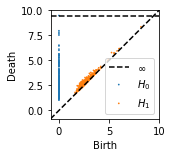

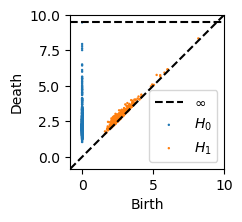

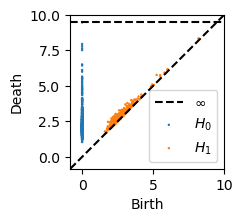

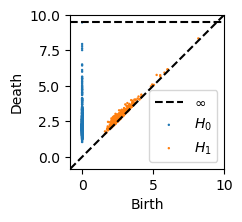

In [12]:
rips = Rips()
diagrams_in = rips.fit_transform(manifold_sampler.to_1d(manifold_sampler.pivots))
plt.figure(figsize = (2,2))
rips.plot(diagrams_in, size=3)

diagrams_gauss = rips.fit_transform(gauss_pc)
plt.figure(figsize = (2,2))
rips.plot(diagrams_gauss, size=3)

diagrams_plane = rips.fit_transform(plane_pc)
plt.figure(figsize = (2,2))
rips.plot(diagrams_plane, size=3)

diagrams_ortho = rips.fit_transform(ortho_pc)
plt.figure(figsize = (2,2))
rips.plot(diagrams_ortho, size=3)

In [13]:
from persim import plot_diagrams, bottleneck

In [ ]:
for i in [0,1]:
    print(bottleneck(diagrams_in[i], diagrams_gauss[i]))
    print(bottleneck(diagrams_in[i], diagrams_plane[i]))
    print(bottleneck(diagrams_in[i], diagrams_ortho[i]))

/home/minhvu/blue_minhvu/Python_geometric/lib/python3.8/site-packages/persim/bottleneck.py:56: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
/home/minhvu/blue_minhvu/Python_geometric/lib/python3.8/site-packages/persim/bottleneck.py:66: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(


5.245208740234375e-06
4.3392181396484375e-05


In [12]:
load_file = 'result/bottleneck/mnist_label_2_dim_3_std_1.0_.pickle'

with open(load_file, 'rb') as file:
    load_data = pickle.load(file)

df = load_data


In [13]:
df

,H0_gauss,H1_gauss,H0_plane,H1_plane,H0_ortho,H1_ortho
0,0.008545,0.006811,0.025362,0.048375,0.008689,0.006073
1,0.007503,0.006985,0.028409,0.048845,0.006747,0.006441
2,0.005386,0.007897,0.022072,0.048146,0.005627,0.007590
3,0.006062,0.009367,0.028733,0.043466,0.006196,0.009570
4,0.007030,0.008097,0.029806,0.042170,0.005871,0.008267
5,0.008536,0.007692,0.022412,0.049284,0.008241,0.006437
6,0.008783,0.009260,0.036090,0.043511,0.008335,0.008338
7,0.007471,0.007937,0.036342,0.039250,0.007175,0.007724
8,0.007995,0.006967,0.026562,0.042539,0.008390,0.006657
9,0.006050,0.007938,0.023663,0.038771,0.006074,0.007652
